In [1]:
import os
import glob
from sklearn.model_selection import train_test_split

# 1. FIX: Correct the path construction
# If 'path' comes from kagglehub, it usually points directly to the dataset root.
# Let's adjust this to find the actual 'train' or data folder.

path = "/kaggle/input/new-plant-diseases-dataset"
dataset_root = os.path.join(path, 'New Plant Diseases Dataset(Augmented)', 'New Plant Diseases Dataset(Augmented)', 'train')

# SAFETY CHECK: If the path above fails, let's see what's actually there
if not os.path.exists(dataset_root):
    print(f"Path not found: {dataset_root}")
    print("Contents of base path:", os.listdir(path))
    # Fallback: Just use the path directly if it contains the folders
    dataset_root = path 

# Initialize lists
all_image_paths = []
all_image_labels = []

# Iterate through subdirectories
try:
    for label in os.listdir(dataset_root):
        label_dir_path = os.path.join(dataset_root, label)

        if os.path.isdir(label_dir_path):
            # Look for images (case-insensitive search is better)
            image_files = []
            for ext in ('*.JPG', '*.jpg', '*.jpeg', '*.PNG', '*.png'):
                image_files.extend(glob.glob(os.path.join(label_dir_path, ext)))

            all_image_paths.extend(image_files)
            all_image_labels.extend([label] * len(image_files))

    if len(all_image_paths) > 0:
        X_train, X_val, y_train, y_val = train_test_split(
            all_image_paths, all_image_labels, test_size=0.2, random_state=42
        )
        print(f"Successfully loaded {len(all_image_paths)} images.")
        print(f"Classes found: {len(os.listdir(dataset_root))}")
    else:
        print("No images found. Check if dataset_root points to the folder containing label subfolders.")

except FileNotFoundError:
    print(f"Error: Could not find directory {dataset_root}. Check your path variable.")

Successfully loaded 70295 images.
Classes found: 38


In [2]:
import tensorflow as tf

# 1. Define image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224

# 2. Re-create a dictionary to map labels to integers and vice versa
unique_labels = sorted(list(set(all_image_labels)))
label_to_index = {label: i for i, label in enumerate(unique_labels)}
index_to_label = {i: label for i, label in enumerate(unique_labels)}

print(f"Number of unique labels: {len(unique_labels)}")
print(f"First 5 label to index mappings: {list(label_to_index.items())[:5]}")

# 3. Re-define the preprocessing function
def preprocess_image(image_path, label):
    # Read the image file
    img = tf.io.read_file(image_path)
    # Decode the JPEG image
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize the image
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    # Normalize the image to [0, 1]
    img = img / 255.0

    # Convert string label to integer index
    # Use tf.py_function to wrap Python dictionary lookup for TF Graph compatibility
    def _get_label_index(lbl):
        return label_to_index[lbl.numpy().decode('utf-8')]

    # The tf.py_function requires input and output types
    label_index = tf.py_function(
        _get_label_index,
        inp=[label],
        Tout=tf.int32
    )
    # Ensure the shape is defined
    label_index.set_shape([])

    return img, label_index

# 4. Re-create TensorFlow Datasets for training and validation
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# 5. Apply the preprocessing function to the datasets
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

print("Training and validation datasets created and preprocessed.")
print(f"Example of preprocessed training data structure: {tf.data.experimental.get_structure(train_ds)}")

2026-02-19 17:10:29.412582: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771521029.590888      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771521029.643123      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771521030.087260      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771521030.087312      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771521030.087315      24 computation_placer.cc:177] computation placer alr

Number of unique labels: 38
First 5 label to index mappings: [('Apple___Apple_scab', 0), ('Apple___Black_rot', 1), ('Apple___Cedar_apple_rust', 2), ('Apple___healthy', 3), ('Blueberry___healthy', 4)]
Training and validation datasets created and preprocessed.
Example of preprocessed training data structure: (TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))


I0000 00:00:1771521052.176660      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


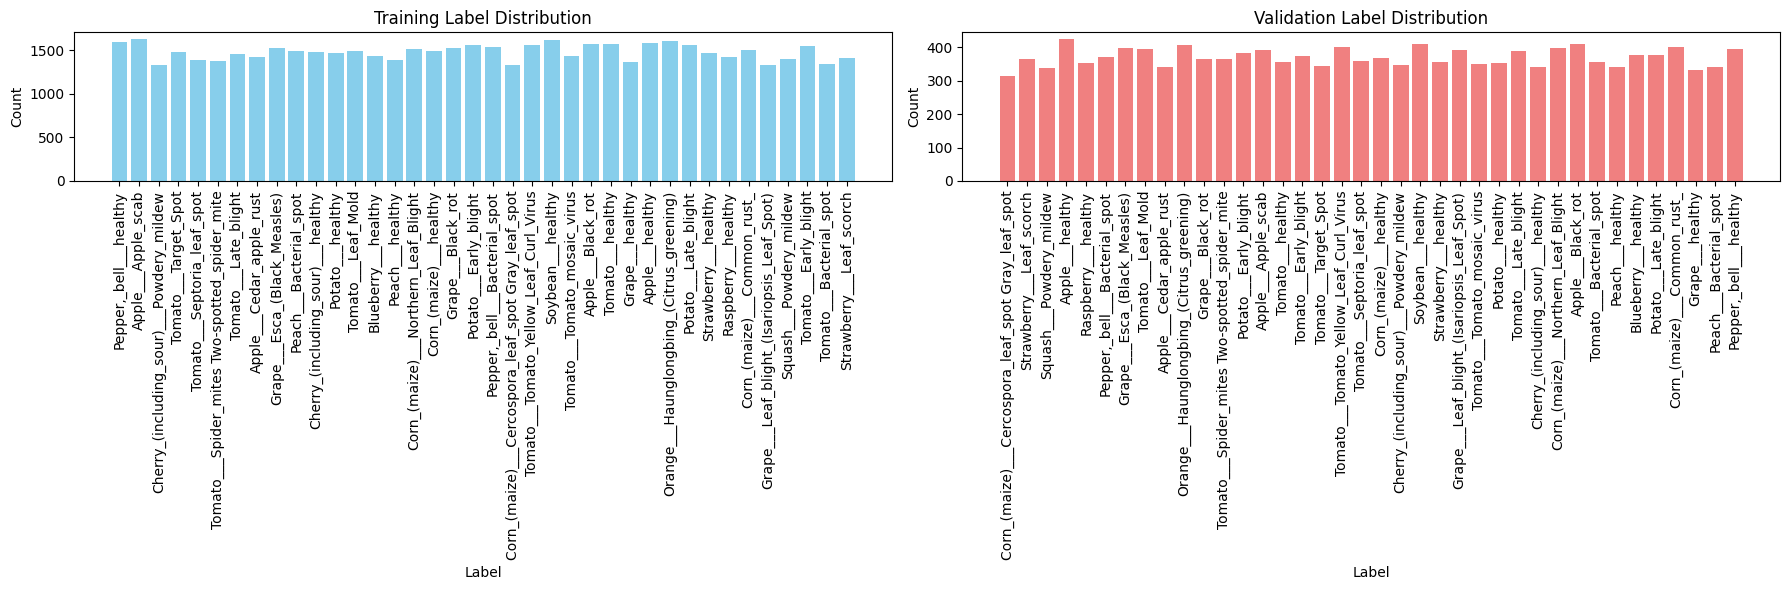

Bar charts showing label distribution for training and validation datasets have been generated.


In [3]:
import matplotlib.pyplot as plt
from collections import Counter

# Create a Counter object for y_train
train_label_counts = Counter(y_train)

# Create a Counter object for y_val
val_label_counts = Counter(y_val)

# Prepare data for plotting
train_labels = list(train_label_counts.keys())
train_counts = list(train_label_counts.values())

val_labels = list(val_label_counts.keys())
val_counts = list(val_label_counts.values())

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot for training label distribution
axes[0].bar(train_labels, train_counts, color='skyblue')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_title('Training Label Distribution')
axes[0].tick_params(axis='x', rotation=90)

# Plot for validation label distribution
axes[1].bar(val_labels, val_counts, color='lightcoral')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_title('Validation Label Distribution')
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout and display plots
plt.tight_layout()
plt.show()

print("Bar charts showing label distribution for training and validation datasets have been generated.")

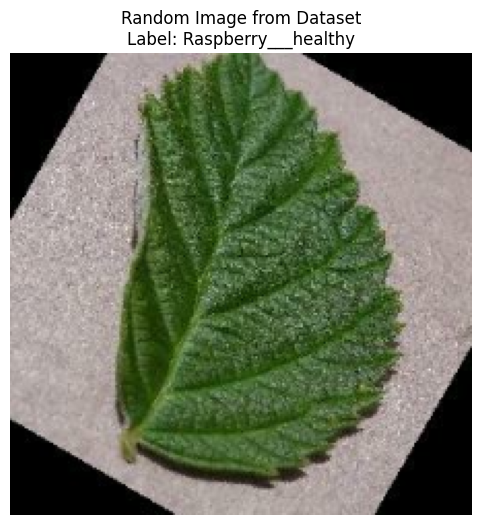

Displayed Image Path: /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Raspberry___healthy/894cf725-37b5-498f-beae-d1a9a3e32bac___Mary_HL 6388_new30degFlipLR.JPG
Displayed Image Label: Raspberry___healthy


In [4]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf

# Select a random image from the full dataset (before splitting)
random_index = random.randint(0, len(all_image_paths) - 1)
random_image_path = all_image_paths[random_index]
random_image_label = all_image_labels[random_index]

# Preprocess the image (decode, resize, normalize) similar to how it's done for training
img = tf.io.read_file(random_image_path)
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
img = img / 255.0 # Normalize

# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f"Random Image from Dataset\nLabel: {random_image_label}")
plt.axis('off')
plt.show()

print(f"Displayed Image Path: {random_image_path}")
print(f"Displayed Image Label: {random_image_label}")

In [5]:
from tensorflow.keras import layers

# Create a data augmentation model
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(height_factor=0.2, width_factor=0.2)
])

# Apply data augmentation to the training dataset
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)

print("Data augmentation model created and applied to the training dataset.")
print(f"Example of augmented training data structure: {tf.data.experimental.get_structure(augmented_train_ds)}")

Data augmentation model created and applied to the training dataset.
Example of augmented training data structure: (TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))


In [6]:
print(train_ds)

<_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>


In [7]:
num_classes = len(set(y.numpy() for x, y in train_ds))
print(num_classes)

38


In [8]:
BATCH_SIZE = 32 # Assuming BATCH_SIZE is defined, otherwise define it

# Apply batching and prefetching to the augmented training dataset
augmented_train_ds = augmented_train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Apply batching and prefetching to the validation dataset
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Training and validation datasets batched and prefetched.")
print(f"Example of batched and prefetched training data structure: {tf.data.experimental.get_structure(augmented_train_ds)}")

Training and validation datasets batched and prefetched.
Example of batched and prefetched training data structure: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [9]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = num_classes

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import Adam

# 1. Define IMG_SHAPE
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

# Re-create data augmentation model here to ensure it's not 'built' with 3D input from dataset.map
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(height_factor=0.2, width_factor=0.2)
])

# 2. Load the MobileNetV2 base model
base_model = MobileNetV2(input_shape=IMG_SHAPE,
                         include_top=False,
                         weights='imagenet')

# 3. Freeze the base model's layers
base_model.trainable = False

# 4. Create a custom classification head
global_average_layer = GlobalAveragePooling2D()
dense_layer = Dense(len(unique_labels), activation='softmax')

# 5. Build the complete model using the functional API
inputs = tf.keras.Input(shape=IMG_SHAPE)
# When 'inputs' is passed, it has a batch dimension (None, H, W, C).
# data_augmentation will now correctly build itself to accept this 4D input.
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = dense_layer(x)

model = Model(inputs, outputs)

# 6. Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# 7. Print model summary
print("Model summary:")
model.summary()

print("Transfer learning model (MobileNetV2) constructed and compiled successfully.")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,306,662 (8.80 MB)

 Trainable params: 48,678 (190.15 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Transfer learning model (MobileNetV2) constructed and compiled successfully.


In [11]:
EPOCHS = 15
history = model.fit(
    augmented_train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

print("Model training complete.")

Epoch 1/15


I0000 00:00:1771521152.920852      64 cuda_dnn.cc:529] Loaded cuDNN version 91002


1758/1758 ━━━━━━━━━━━━━━━━━━━━ 350s 195ms/step - accuracy: 0.4137 - loss: 2.3716 - val_accuracy: 0.7668 - val_loss: 0.9583
Epoch 2/15
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 327s 186ms/step - accuracy: 0.8167 - loss: 0.7618 - val_accuracy: 0.8151 - val_loss: 0.6845
Epoch 3/15
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 329s 187ms/step - accuracy: 0.8565 - loss: 0.5473 - val_accuracy: 0.8372 - val_loss: 0.5765
Epoch 4/15
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 326s 185ms/step - accuracy: 0.8744 - loss: 0.4604 - val_accuracy: 0.8462 - val_loss: 0.5248
Epoch 5/15
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 326s 185ms/step - accuracy: 0.8849 - loss: 0.4096 - val_accuracy: 0.8508 - val_loss: 0.4965
Epoch 6/15
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 326s 185ms/step - accuracy: 0.8940 - loss: 0.3735 - val_accuracy: 0.8606 - val_loss: 0.4613
Epoch 7/15
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 327s 186ms/step - accuracy: 0.9014 - loss: 0.3427 - val_accuracy: 0.8631 - val_loss: 0.4509
Epoch 8/15
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 328s 186ms/step - accuracy: 0.9

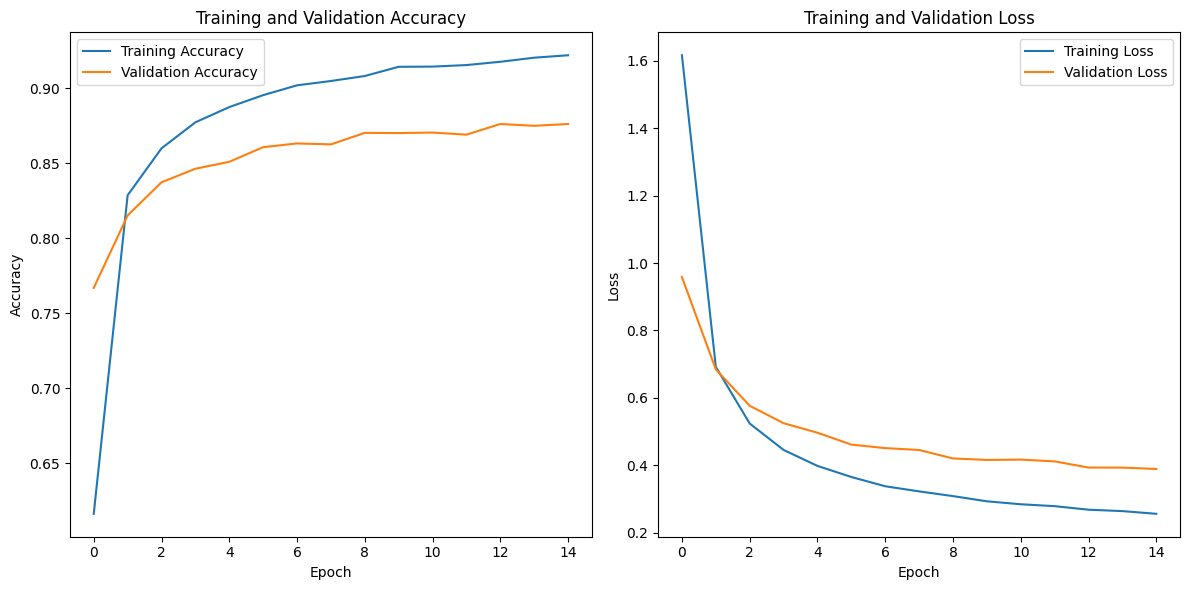

Training and validation accuracy and loss curves have been plotted.


In [12]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
plt.figure(figsize=(12, 6))

# Subplot 1: Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Subplot 2: Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display plots
plt.tight_layout()
plt.show()

print("Training and validation accuracy and loss curves have been plotted.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


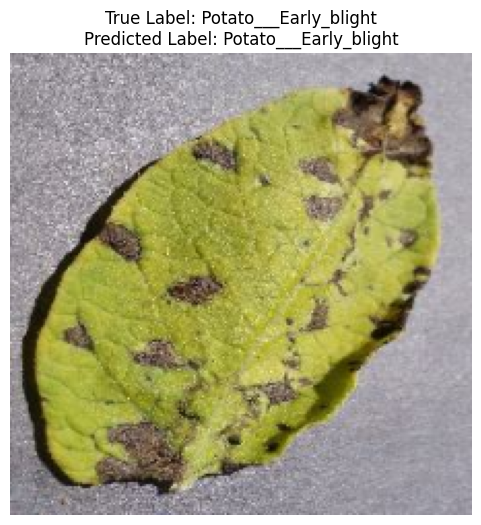

Test Image Path: /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Potato___Early_blight/acb84d77-5b1c-4beb-be27-99fee467bf1f___RS_Early.B 7577.JPG
True Label: Potato___Early_blight
Predicted Label: Potato___Early_blight
Prediction Probabilities: [2.31762696e-03 3.78967275e-06 2.78979878e-05 6.16787247e-07
 3.16088382e-08 1.75114073e-05 1.57361246e-05 2.49354827e-07
 7.59343521e-08 9.47682466e-08 1.05866453e-08 7.46480282e-06
 1.07538376e-07 8.83780536e-04 2.81172220e-07 2.04928438e-06
 1.15209282e-03 3.85564505e-08 8.71403681e-05 9.42541334e-08
 9.87819791e-01 6.20090170e-04 1.61215678e-06 3.00310035e-06
 2.66099107e-07 5.10139785e-07 1.78514179e-04 3.79097060e-06
 4.45110636e-04 7.64898316e-04 4.62291719e-05 3.19314422e-05
 4.73805377e-03 2.47751159e-04 3.30814248e-04 1.77773138e-04
 2.06960722e-05 5.24818206e-05]


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Find an image that is not in X_train or X_val to use as a test image
# For simplicity, let's just pick one from all_image_paths that is not in X_val (it might be in X_train, but for a quick demo it's fine)
# A more robust approach would be to ensure it's not in either, or load a truly new image.

# Let's try to find an image that is likely to be outside the training and validation sets for a better demonstration
# Or, for demonstration purposes, we can just pick one from X_val and see how it performs.
# Let's pick a random image from the validation set to demonstrate the prediction process.
import random

random_index = random.randint(0, len(X_val) - 1)
test_image_path = X_val[random_index]
true_label = y_val[random_index]

# Preprocess the test image
img = tf.io.read_file(test_image_path)
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
img = img / 255.0 # Normalize

# Add a batch dimension (model expects a batch of images)
img_batch = tf.expand_dims(img, axis=0)

# Make prediction
predictions = model.predict(img_batch)
predicted_class_index = np.argmax(predictions[0])
predicted_label = index_to_label[predicted_class_index]

# Display the image and prediction
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")
plt.axis('off')
plt.show()

print(f"Test Image Path: {test_image_path}")
print(f"True Label: {true_label}")
print(f"Predicted Label: {predicted_label}")
print(f"Prediction Probabilities: {predictions[0]}")


In [14]:
import os
print(os.listdir("/kaggle/input/datasets/ahmed1harfoush/plant-disease-treatment"))


['plant_disease_treatment.json']


In [15]:
import json

class_names = unique_labels

with open("/kaggle/input/datasets/ahmed1harfoush/plant-disease-treatment/plant_disease_treatment.json", "r") as f:
    disease_info = json.load(f)


In [16]:
print(list(disease_info.keys())[:5])
print(unique_labels[:5])


['Apple__Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']


In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

def predict_disease(img_path, model, class_names):
    # 1. Load and resize the image
    img = image.load_img(img_path, target_size=(224, 224))
    
    # 2. Convert to array and normalize (scaling pixels to 0-1)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Crucial step for model accuracy
    
    # 3. Add batch dimension (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)

    # 4. Make prediction
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    confidence = np.max(prediction)

    # 5. Get the class name from our list
    predicted_class = class_names[class_index]

    # 6. Fetch info from disease_info dictionary (ensure this is loaded)
    info = disease_info.get(predicted_class, {})

    disease_name = info.get("disease_name", predicted_class)
    treatment = info.get("treatment", "No treatment info available")
    prevention = info.get("prevention", "No prevention info")
    notes = info.get("notes", "")

    # 7. Print Results
    print("-" * 30)
    print(f"Detected Class: {predicted_class}")
    print(f"Confidence: {float(confidence):.2%}")
    print(f"Disease Name: {disease_name}")
    print(f"Treatment: {treatment}")
    print(f"Prevention: {prevention}")
    print(f"Notes: {notes}")
    print("-" * 30)

In [18]:
# Replace with a valid image path from your dataset
# Using test_image_path which was successfully generated in a previous cell
predict_disease(
    test_image_path, 
    model, 
    unique_labels # Use the variable we identified earlier
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
------------------------------
Detected Class: Potato___Early_blight
Confidence: 96.20%
Disease Name: Potato Early Blight
Treatment: Apply fungicides like chlorothalonil or mancozeb.
Prevention: Plant resistant cultivars; rotate crops every 3 years.
Notes: Dark concentric rings appear on older leaves.
------------------------------


In [19]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open("plant_disease_model.tflite", "wb") as f:
    f.write(tflite_model)

print("Model saved as plant_disease_model.tflite")


INFO:tensorflow:Assets written to: /tmp/tmprqvfqom5/assets


INFO:tensorflow:Assets written to: /tmp/tmprqvfqom5/assets


Saved artifact at '/tmp/tmprqvfqom5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_158')
Output Type:
  TensorSpec(shape=(None, 38), dtype=tf.float32, name=None)
Captures:
  136817417647312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136817417649040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136817417648848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136817417648464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136817417649616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136817417648080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136817417649232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136817417648272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136817417649424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136817417647888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136817394

W0000 00:00:1771526136.340969      24 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1771526136.341037      24 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1771526136.516909      24 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


In [20]:
import json

with open("class_names.json", "w") as f:
    json.dump(class_names, f)

print("Class names saved")

Class names saved
